# 1. Título
SRAG 2021/2022 - Banco de Dados de Síndrome Respiratória Aguda Grave - incluindo dados da COVID-19

# 2. Membros (nome e número de matrícula)
Mirna Mendonça e Silva - 2021421940

Vinicius Silva Gomes - 2021421869

Jair Paulo Junior de Arruda Carvalho - 2021032200

# 3. Descrição dos dados (qual a URL? qual o domínio? como os dados foram processados?)

**URL:** https://opendatasus.saude.gov.br/dataset/srag-2021-e-2022

**Domínio:** Saúde

**Processamento dos dados:** Baixamos o arquivo CSV original com mais de um milhão e setecentos mil registros e usamos o comando AWK para isolar apenas os registros onde as unidades de saúde fossem de Minas Gerais, resultando em cerca de duzentos e seis mil registros. O tempo de execução, porém, ainda estava muito grande (cerca de três horas) então, no próprio Excel, excluímos os registros de todas as unidades de saúde que não fossem de Belo Horizonte. Logo, todas as nossas consultas se referem às unidades de saúde que estão em Belo Horizonte, totalizando cerca de quarenta e seis mil registros.

Para facilitar o processamento e encapsular melhor nosso universo de mapeamento, após filtrar as linhas, excluímos todas as colunas que não eram interessantes para a nossa abordagem, permanecendo, assim, cerca de 41 colunas.

Além disso, foi feito um script em Python que manipula o CSV de modo a montar as querys SQL que seriam inseridas no banco. O script adiciona os esquemas de cada tabela gerada no Modelo Relacional; cria as querys de inserção para os Sintomas e Fatores de Risco (dados estáticos extraídos das colunas do CSV); cria as querys de inserção de Unidades de Saúde, garantindo que não haja duplicidade de registro; cria as querys de Paciente, percorrendo linha a linha o CSV; e, por fim, insere as informações dos relacionamentos entre Paciente e Sintomas e Paciente e Fatores de Risco, percorrendo cada linha do CSV e manipulando para o seu respectivo paciente.

Dessa forma, ao final, obtemos um arquivo .sql com todos os códigos necessários para montar o banco de dados mapeado pelo nosso grupo.

O link do GitHub com o código Python, o CSV e os arquivos resultantes .sql do código podem ser acessados através [desse link](https://github.com/vinisilvag/ibd-tp2).

Também foi feito um Dicionário de Dados para documentação de cada relação do banco. Ele pode ser acessado através [desse link](https://docs.google.com/document/d/1Pg2GMkg4HeUD0bExQcQZDmmngnVHH9CIVWbsy8a0xdA/edit?usp=sharing).

**Diferenças entre o modelo apresentado e o modelo proposto na primeira parte do relatório:** Esse tópico aqui foi adicionado para abordar as diferenças entre esse modelo que está sendo apresentado e o modelo que foi enviado na primeira proposta. Essa mudança ocorreu pois nos deparamos com muitos problemas ao longo da análise e manipulação do banco de dados para SQL. O principal problema foi quanto aos atributos: muitos deles estavam definidos no dicionário de dados mas não estavam presentes em forma de colunas no CSV. Dessa forma, parte da nossa modelagem perdia sentido, criando a necessidade de algumas alterações no esquema para que ele ainda faça sentido e esteja montado de maneira coesa e correta.

Além disso, como explicado mais acima, nem todas as instâncias foram utilizadas. Como era um banco muito extenso, com aproximadamente um milhão e setecentos mil registros, optamos por fazer um corte e representar só os registros que aconteceram em Unidades de Saúde de Belo Horizonte, reduzindo esse número para quarenta e seis mil. Dessa forma, a manipulação foi mais simples e ainda assim foi possível tirar algumas conclusões a respeito do banco de dados. Essa redução foi necessária devido ao alto custo de RAM para alguns processamentos simples, como a manipulação das colunas necessárias, a criação do arquivo SQL, entre outras; e a grande demora para realizar essas tarefas, que tornava quase que inviável.

Dessa maneira, após uma nova análise, mais concisa e profunda, nós elaboramos um novo mapeamento, um pouco mais direcionado para o paciente, a Unidade de Saúde que ele visitou (duas entidades que permaneceram mesmo após a nova abordagem) e os sintomas e fatores de risco que ele apresenta quando foi cadastrado. Com esse novo modelo, conseguimos informações melhor organizadas e mais concisas do que seria obtido no modelo anterior, graças a falta de atributos. Assim, conseguimos contornar o problema da falta de atributos e da quantidade extensa de dados, criando um modelo ainda muito pertinente para análises estatísticas, assim como pretendido no mundo real.



# 4. Diagrama ER

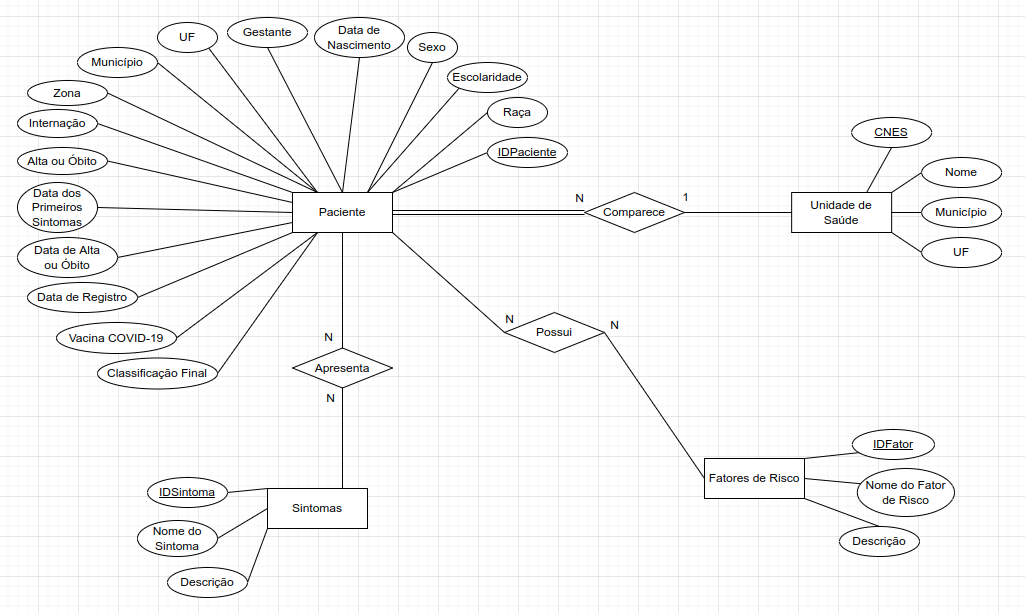

# 5. Diagrama relacional

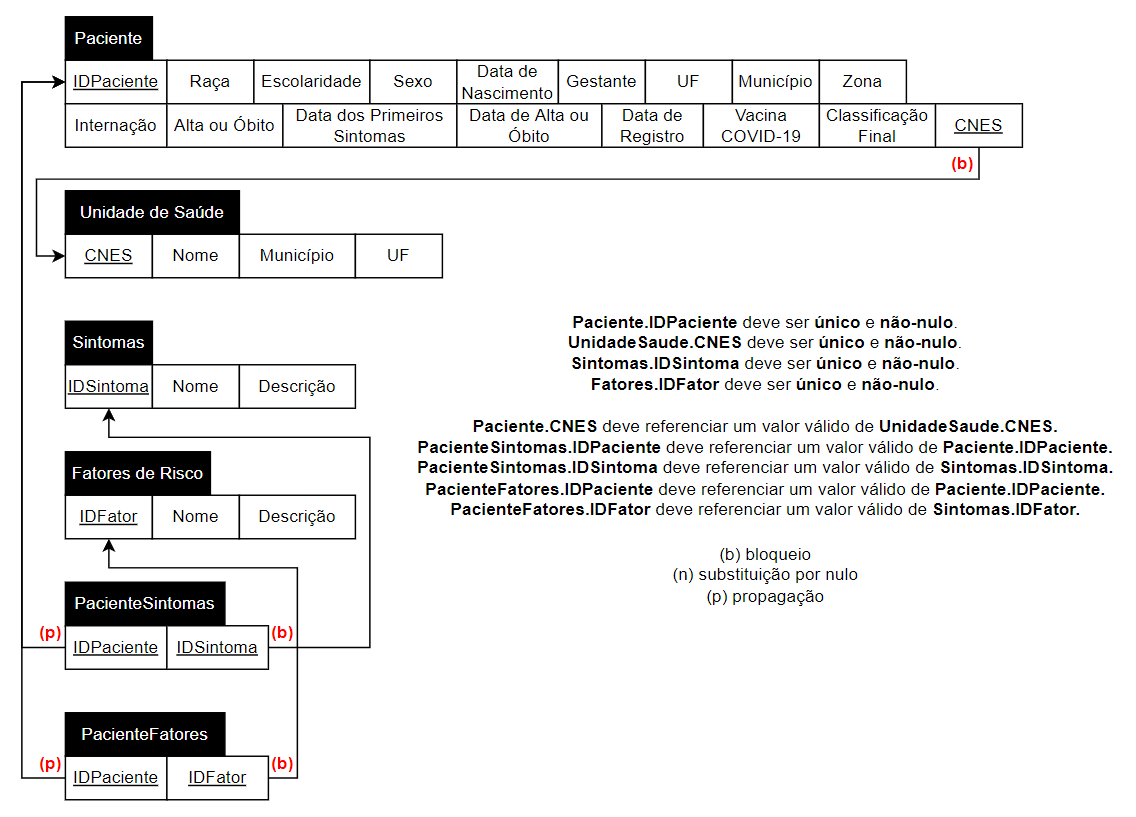

# 6. Consultas

In [1]:
import io
import sqlite3
import pandas as pd

In [2]:
!wget --quiet -P /tmp/ https://raw.githubusercontent.com/vinisilvag/ibd-tp2/main/entities.sql
!wget --quiet -P /tmp/ https://raw.githubusercontent.com/vinisilvag/ibd-tp2/main/relationships.sql

conn = sqlite3.connect('/tmp/consult.db')
cursor = conn.cursor()

entities = io.open('/tmp/entities.sql', 'r', encoding='utf-8')
sql = entities.read()
cursor.executescript(sql)

relationships = io.open('/tmp/relationships.sql', 'r', encoding='utf-8')
sql = relationships.read()
cursor.executescript(sql)

## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1 (duas versões)

Data de registro (distintas) dos pacientes que tiveram SRAG por COVID-19

Primeira versão: Seleciona distintamente as datas de registro da tabela paciente onde a classificação final é "SRAG por covid-19"

In [3]:
query = """
SELECT DISTINCT
  DataRegistro
FROM 
  Paciente as P
WHERE
  ClassificacaoFinal = "SRAG por covid-19"
"""

df = pd.read_sql_query(query, conn)
df

,DataRegistro
0,15-01-21
1,14-01-21
2,23-02-21
3,26-02-21
4,29-01-21
...,...
352,23-11-21
353,30-12-21
354,04-12-21
355,26-11-21


Segunda versão: Seleciona as datas de registro da tabela paciente, agrupando pela classificação final e pela data de registro, selecionando aqueles que tem a classificação como "SRAG por covid-19"

In [4]:
query = """
SELECT 
  DataRegistro
FROM 
  Paciente as P
GROUP BY
  ClassificacaoFinal, DataRegistro
HAVING
  ClassificacaoFinal = "SRAG por covid-19"
"""

df = pd.read_sql_query(query, conn)
df

,DataRegistro
0,01-02-21
1,01-03-21
2,01-04-21
3,01-05-21
4,01-06-21
...,...
352,31-03-21
353,31-05-21
354,31-07-21
355,31-08-21


### 6.1.2 Consulta 2 (duas versões)

Município dos pacientes que são ou já foram de zona rural

Primeira versão: Seleciona os municípios da tabela paciente onde a zona é "Rural"

In [5]:
query = """
SELECT 
  Municipio
FROM 
  Paciente as P
WHERE
  Zona = "Rural"
"""

df = pd.read_sql_query(query, conn)
df

,Municipio
0,ITABIRITO
1,GRAO MOGOL
2,CARMO DO CAJURU
3,BELO VALE
4,CARMOPOLIS DE MINAS
...,...
222,BELO HORIZONTE
223,BELO HORIZONTE
224,PAPAGAIOS
225,PADRE PARAISO


Segunda versão: Seleciona os municípios da tabela paciente onde a zona está na subquery que encontra as zonas que tem como valor "Rural"

In [6]:
query = """
SELECT 
  Municipio
FROM 
  Paciente AS P
WHERE
  P.Zona IN (
    SELECT
      P.Zona
    FROM
      Paciente AS P
    WHERE 
      P.Zona = "Rural")
"""

df = pd.read_sql_query(query, conn)
df

,Municipio
0,ITABIRITO
1,GRAO MOGOL
2,CARMO DO CAJURU
3,BELO VALE
4,CARMOPOLIS DE MINAS
...,...
222,BELO HORIZONTE
223,BELO HORIZONTE
224,PAPAGAIOS
225,PADRE PARAISO


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3 (duas versões)

Nome das unidades de saúde que tiveram mortes

Primeira versão: Seleciona distintamente a coluna nome da tabela Unidade de Saúde que faz um Inner Join com a tabela paciente usando como base a coluna CNES comum às duas tabelas e seleciona os CNES das unidades de saúde que estiverem na subquery que encontra os pacientes que morreram.

In [7]:
query = """
SELECT DISTINCT
  Un.Nome
FROM 
  UnidadeSaude as Un
  INNER JOIN Paciente as P
    ON Un.CNES = P.CNES
WHERE
  Un.CNES IN (SELECT
                P2.CNES
              FROM
                Paciente as P2
              WHERE
                P2.AltaOuObito = "Óbito" OR P2.AltaOuObito = "Óbito por outras causas")
"""

df = pd.read_sql_query(query, conn)
df

,Nome
0,HOSPITAL SEMPER
1,HOSPITAL INFANTIL JOAO PAULO II
2,UNIDADE DE PRONTO ATENDIMENTO NOROESTE II HOB
3,BH HOSPITAL GOVERNADOR ISRAEL PINHEIRO HGIP
4,LIFECENTER SISTEMA DE SAUDE S A
5,HOSPITAL UNIMED UNIDADE CONTORNO
6,HOSPITAL JULIA KUBITSCHEK
7,SANTA CASA DE BELO HORIZONTE
8,HOSPITAL INFANTIL SAO CAMILO UNIMED
9,COMPLEXO HOSPITALAR SAO FRANCISCO


Segunda versão: Seleciona distintamente a coluna nome da tabela Unidade de Saúde que faz um Inner Join com a tabela paciente usando como base a coluna CNES comum às duas tabelas e seleciona os pacientes que morreram.

In [8]:
query = """
SELECT DISTINCT
  Un.Nome
FROM
  UnidadeSaude AS Un INNER JOIN Paciente AS P ON Un.CNES = P.CNES
WHERE
  P.AltaOuObito = "Óbito" OR P.AltaOuObito = "Óbito por outras causas"
"""

df = pd.read_sql_query(query, conn)
df

,Nome
0,UNIDADE DE PRONTO ATENDIMENTO NOROESTE II HOB
1,SANTA CASA DE BELO HORIZONTE
2,HOSPITAL JULIA KUBITSCHEK
3,HOSPITAL METROPOLITANO ODILON BEHRENS HOB
4,HOSPITAL EVANGELICO DE BELO HORIZONTE
5,HOSPITAL KERALTY
6,HOSPITAL RISOLETA TOLENTINO NEVES
7,UNIDADE DE PRONTO ATENDIMENTO BARREIRO
8,UNIDADE DE PRONTO ATENDIMENTO LESTE
9,BIOCOR INSTITUTO


### 6.2.2 Consulta 4 (duas versões)

CNES das unidades de saúde que tem pacientes gestantes ou que já foram gestantes

Primeira versão: Seleciona distintamente a coluna CNES da tabela Unidade de Saúde que faz um Inner Join com a tabela paciente usando como base a coluna CNES comum às duas tabelas e seleciona os CNES das unidades de saúde que estiverem na subquery que encontra os pacientes que são gestantes.

In [9]:
query = """
SELECT DISTINCT
  Un.CNES
FROM 
  UnidadeSaude as Un
  INNER JOIN Paciente as P
    ON Un.CNES = P.CNES
WHERE
  Un.CNES IN (SELECT
                P2.CNES
              FROM
                Paciente as P2
              WHERE
                P2.Gestante = 1)
"""

df = pd.read_sql_query(query, conn)
df

,CNES
0,2181770
1,2192896
2,2200422
3,23310
4,23582
5,26794
6,26808
7,26840
8,27014
9,27022


Segunda versão: Seleciona distintamente a coluna nome da tabela Unidade de Saúde que faz um Inner Join com a tabela paciente usando como base a coluna CNES comum às duas tabelas e seleciona os pacientes que são gestantes.

In [10]:
query = """
SELECT DISTINCT
  Un.CNES
FROM 
  UnidadeSaude AS Un INNER JOIN Paciente P ON Un.CNES = P.CNES
WHERE
  P.Gestante = 1
"""

df = pd.read_sql_query(query, conn)
df

,CNES
0,27014
1,27863
2,27022
3,26794
4,27049
5,23582
6,2192896
7,3702693
8,2200422
9,9068279


### 6.2.3 Consulta 5 (duas versões)

Estado das unidades de saúde que tem pacientes internados ou que já foram internados

Primeira versão: Seleciona distintamente a coluna UF da tabela Unidade de Saúde que faz um Inner Join com a tabela paciente usando como base a coluna CNES comum às duas tabelas e seleciona os CNES das unidades de saúde que estiverem na subquery que encontra os pacientes que estão internados.

In [11]:
query = """
SELECT DISTINCT
  Un.UF
FROM 
  UnidadeSaude as Un
  INNER JOIN Paciente as P
    ON Un.CNES = P.CNES
WHERE
  Un.CNES IN (SELECT
                P2.CNES
              FROM
                Paciente as P2
              WHERE
                P2.Internacao = 1)
"""

df = pd.read_sql_query(query, conn)
df

,UF
0,MG


Segunda versão: Seleciona distintamente a coluna nome da tabela Unidade de Saúde que faz um Inner Join com a tabela paciente usando como base a coluna CNES comum às duas tabelas e seleciona os pacientes que estão internados.

In [12]:
query = """
SELECT DISTINCT
  Un.UF
FROM 
  UnidadeSaude AS Un INNER JOIN Paciente AS P ON Un.CNES = P.CNES
WHERE
  P.Internacao = 1
  
"""

df = pd.read_sql_query(query, conn)
df

,UF
0,MG


## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6 (duas versões)

Nome e descrição dos sintomas dos pacientes da cidade de Formiga

Primeira versão: Seleciona as colunas nome do sintoma e descrição da tabela Sintoma que faz um Inner Join com a tabela que relaciona cada paciente com seus sintomas usando como base a coluna IDSintoma comum às duas tabelas e faz mais um Inner Join com a tabela paciente usando como base a coluna IDPaciente comum às duas tabelas e seleciona os pacientes com o valor do município como "Formiga"

In [13]:
query = """
SELECT 
  S.NomeSintoma, S.Descricao
FROM 
  Sintomas as S
  INNER JOIN PacienteSintomas as PS
    ON PS.IDSintoma = S.IDSintoma
  INNER JOIN Paciente as P
    ON P.IDPaciente = PS.IDPaciente
WHERE
  P.Municipio = "FORMIGA"
"""

df = pd.read_sql_query(query, conn)
df

,NomeSintoma,Descricao
0,Febre,Elevação da temperatura corporal acima de um v...
1,Tosse,"Expulsão súbita e ruidosa de ar pela boca, vis..."
2,Desconforto Respiratório,O desconforto respiratório surge como consequê...
3,Diarréia,"Aumento do volume, frequência ou quantidade de..."
4,Dispneia,Sensação subjetiva de falta de ar.
...,...,...
56,Dor Abdominal,Dor abdominal é aquela sentida em qualquer reg...
57,Febre,Elevação da temperatura corporal acima de um v...
58,Desconforto Respiratório,O desconforto respiratório surge como consequê...
59,Tosse,"Expulsão súbita e ruidosa de ar pela boca, vis..."


Segunda versão: Seleciona as colunas nome do sintoma e descrição da tabela Sintoma que faz um Inner Join com a tabela que relaciona cada paciente com seus sintomas usando como base a coluna IDSintoma comum às duas tabelas e faz mais um Inner Join com a tabela paciente usando como base a coluna IDPaciente comum às duas tabelas e seleciona os pacientes que estão na subquery que encontra os pacientes com o município com o valor "Formiga"

In [14]:
query = """
SELECT 
  S.NomeSintoma, S.Descricao
FROM
  Sintomas AS S INNER JOIN PacienteSintomas AS PS ON S.IDSintoma = PS.IDSintoma
WHERE
  PS.IDPaciente IN (
    SELECT
      P.IDPaciente
    FROM
      Paciente AS P
    WHERE
      P.Municipio = "FORMIGA")

"""

df = pd.read_sql_query(query, conn)
df

,NomeSintoma,Descricao
0,Febre,Elevação da temperatura corporal acima de um v...
1,Tosse,"Expulsão súbita e ruidosa de ar pela boca, vis..."
2,Desconforto Respiratório,O desconforto respiratório surge como consequê...
3,Diarréia,"Aumento do volume, frequência ou quantidade de..."
4,Dispneia,Sensação subjetiva de falta de ar.
...,...,...
56,Dor Abdominal,Dor abdominal é aquela sentida em qualquer reg...
57,Febre,Elevação da temperatura corporal acima de um v...
58,Desconforto Respiratório,O desconforto respiratório surge como consequê...
59,Tosse,"Expulsão súbita e ruidosa de ar pela boca, vis..."


### 6.3.2 Consulta 7 (duas versões)

Nome e descrição dos fatores de risco dos pacientes negros

Primeira versão: Seleciona as colunas nome do fator e descrição da tabela fatores de risco que faz um Inner Join com a tabela que relaciona cada paciente com seus fatores de risco usando como base a coluna IDFator comum às duas tabelas e faz mais um Inner Join com a tabela paciente usando como base a coluna IDPaciente comum às duas tabelas e seleciona os pacientes com o valor da raça como "Preta"

In [15]:
query = """
SELECT
  F.NomeFator, F.Descricao
FROM 
  FatoresRisco as F
  INNER JOIN PacienteFatores as PF
    ON PF.IDFator = F.IDFator
  INNER JOIN Paciente as P
    ON P.IDPaciente = PF.IDPaciente
WHERE
  P.Raca = "Preta"
"""

df = pd.read_sql_query(query, conn)
df

,NomeFator,Descricao
0,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
1,Pneumopatia Crônica,As pneumopatias são doenças em que há o compro...
2,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
3,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
4,Doença Renal Crônica,A doença renal crônica é uma diminuição lenta ...
...,...,...
3441,Imunodeficiência ou Imunodepressão,"Imunodeficiência é um grupo de doenças, caract..."
3442,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
3443,Diabetes Mellitus,Diabetes Mellitus é uma doença caracterizada p...
3444,Doença Neurológica Crônica,Entre as condições neurológicas crônicas estão...


Segunda versão: Seleciona as colunas nome do fator e descrição da tabela Sintoma que faz um Inner Join com a tabela que relaciona cada paciente com seus sintomas usando como base a coluna IDFator comum às duas tabelas e faz mais um Inner Join com a tabela paciente usando como base a coluna IDPaciente comum às duas tabelas e seleciona os pacientes que estão na subquery que encontra os pacientes com a raça com o valor "Preta"

In [16]:
query = """
SELECT 
  F.NomeFator, F.Descricao
FROM 
  FatoresRisco AS F INNER JOIN PacienteFatores AS PF ON F.IDFator = PF.IDFator
  INNER JOIN Paciente AS P ON P.IDPaciente = PF.IDPaciente
WHERE P.IDPaciente IN (
  SELECT
    P2.IDPaciente
  FROM
    Paciente AS P2
  WHERE
    P2.Raca = "Preta"
)
"""

df = pd.read_sql_query(query, conn)
df

,NomeFator,Descricao
0,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
1,Pneumopatia Crônica,As pneumopatias são doenças em que há o compro...
2,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
3,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
4,Doença Renal Crônica,A doença renal crônica é uma diminuição lenta ...
...,...,...
3441,Imunodeficiência ou Imunodepressão,"Imunodeficiência é um grupo de doenças, caract..."
3442,Doença Cardiovascular Crônica,As doenças cardiovasculares se caracterizam po...
3443,Diabetes Mellitus,Diabetes Mellitus é uma doença caracterizada p...
3444,Doença Neurológica Crônica,Entre as condições neurológicas crônicas estão...


### 6.3.3 Consulta 8 (duas versões)

Municípios (distintos) dos pacientes com febre

Primeira versão: Seleciona distintamente a coluna município da tabela paciente da tabela resultante do Inner Join da tabela sintoma com a tabela que relaciona cada paciente com seus sintomas usando como base a coluna IDSintoma comum às duas tabelas e de mais um Inner Join com a tabela paciente usando como base a coluna IDPaciente comum às duas tabelas e depois seleciona as linhas com o nome do sintoma "Febre"

In [17]:
query = """
SELECT DISTINCT
  P.Municipio
FROM 
  Sintomas as S
  INNER JOIN PacienteSintomas as PS
    ON PS.IDSintoma = S.IDSintoma
  INNER JOIN Paciente as P
    ON P.IDPaciente = PS.IDPaciente
WHERE
  S.NomeSintoma = "Febre"
"""

df = pd.read_sql_query(query, conn)
df

,Municipio
0,BELO HORIZONTE
1,VESPASIANO
2,CONTAGEM
3,IBIRITE
4,UBA
...,...
453,PEQUI
454,SAO TIAGO
455,SAO JOAO DO MANTENINHA
456,SANTA MARIA DO SALTO


Segunda versão: Seleciona a coluna município da tabela paciente da tabela resultante do Inner Join da tabela sintoma com a tabela que relaciona cada paciente com seus sintomas usando como base a coluna IDSintoma comum às duas tabelas e de mais um Inner Join com a tabela paciente usando como base a coluna IDPaciente comum às duas tabelas e depois agrupa pelo município e pelo ID do sintoma e seleciona aqueles com o nome do sintoma "Febre"

In [18]:
query = """
SELECT 
  P.Municipio
FROM 
  Paciente AS P INNER JOIN PacienteSintomas AS PS ON P.IDPaciente = PS.IDPaciente
  INNER JOIN Sintomas AS S ON S.IDSintoma = PS.IDSintoma
GROUP BY
  P.Municipio, S.IDSintoma
HAVING
  S.NomeSintoma = "Febre"
"""

df = pd.read_sql_query(query, conn)
df

,Municipio
0,ABADIA DOS DOURADOS
1,ABAETE
2,ABAIRA
3,ACAIACA
4,AGUA BOA
...,...
453,VILA BELA DA SANTISSIMA TRINDADE
454,VILA VELHA
455,VIRGEM DA LAPA
456,VIRGOLANDIA


## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9 (duas versões)

Número de pacientes do sexo feminino que tem pelo menos um fator de risco

Primeira versão: Conta de maneira distinta os IDs dos pacientes resultantes do Inner Join da tabela de fatores de risco com a tabela que relaciona os fatores de risco com o paciente, usando como base a coluna IDFator, que é comum às duas tabelas. Além disso, é feita a diferenciação de sexo, através da cláusula Where, selecionando apenas os pacientes do sexo feminino. Dessa forma, é selecionado apenas os pacientes do sexo feminino e que possuem algum fator de risco vinculado ao seu ID.

In [19]:
query = """
SELECT 
  COUNT(DISTINCT P.IDPaciente) as NumeroPacientes
FROM 
  Paciente as P
  INNER JOIN PacienteFatores as PF
    ON P.IDPaciente = PF.IDPaciente
  INNER JOIN FatoresRisco as F
    ON F.IDFator = PF.IDFator
WHERE
  P.Sexo = "F"
"""

df = pd.read_sql_query(query, conn)
df

,NumeroPacientes
0,13111


Segunda versão: Conta de maneira distinta os IDs dos pacientes que são do sexo feminino e que possuem o ID no range de IDs definido pelo segundo SELECT. O segundo SELECT, por sua vez, seleciona os IDs resultantes do Inner Join da tabela de fatores de risco com a tabela de pacientes, através da junção das duas tabelas com a tabela que às relaciona, a FatoresRisco. Em suma, seleciona os IDs dos pacientes que possuem algum fator de risco cadastrado. Dessa forma, o primeiro SELECT define que só serão escolhidas as pacientes do sexo feminino e que possuem algum fator de risco, cujos IDs são definidos pelo segundo SELECT.

In [ ]:
query = """
SELECT 
  COUNT(P.IDPaciente) as NumeroPacientes
FROM
  Paciente AS P
WHERE
  P.Sexo = "F" AND P.IDPaciente IN (SELECT
                                      P2.IDPaciente
                                    FROM
                                      FatoresRisco AS F INNER JOIN PacienteFatores AS PF ON PF.IDFator = F.IDFator
                                      INNER JOIN Paciente AS P2 ON P2.IDPaciente = PF.IDPaciente)
"""

df = pd.read_sql_query(query, conn)
df

,NumeroPacientes
0,13111


### 6.4.2 Consulta 10 (duas versões)

Número de pacientes que foram vacinados para a COVID-19 com pelo menos um sintoma

Primeira versão: Conta todos os IDs de pacientes distintos da tabela resultante do Inner Join da tabela sintoma com a tabela que relaciona cada paciente com seus sintomas usando como base a coluna IDSintoma comum às duas tabelas e de mais um Inner Join com a tabela paciente usando como base a coluna IDPaciente comum às duas tabelas e depois seleciona as linhas com o valor verdadeiro para a coluna Vacina COVID

In [20]:
query = """
SELECT 
  COUNT(DISTINCT P.IDPaciente) as NumeroPacientes
FROM 
  Sintomas as S
  INNER JOIN PacienteSintomas as PS
    ON PS.IDSintoma = S.IDSintoma
  INNER JOIN Paciente as P
    ON P.IDPaciente = PS.IDPaciente
WHERE
  P.VacinaCOVID = 1
"""

df = pd.read_sql_query(query, conn)
df

,NumeroPacientes
0,9603


Segunda versão: Conta todos os IDs de pacientes distintos que tem o valor verdadeiro para a coluna Vacina COVID e que estão na subquery que junta com Inner Joins as tabelas paciente, paciente-sintomas e sintomas, selecionando assim apenas pacientes com sintomas.

In [21]:
query = """
SELECT
  COUNT(P.IDPaciente) as NumeroPacientes
FROM
  Paciente AS P
WHERE
  P.VacinaCOVID = 1 AND P.IDPaciente IN (
SELECT 
  P.IDPaciente
FROM 
  Paciente AS P INNER JOIN PacienteSintomas AS PS ON P.IDPaciente = PS.IDPaciente)
"""

df = pd.read_sql_query(query, conn)
df

,NumeroPacientes
0,9603


# 7. Autoavaliação dos membros

**Mirna Mendonça:** Penso que esse trabalho refletiu bastante a realidade do que seria uma manipulação real e profissional de um banco de dados relativamente grande e nos introduziu às situações que ela cria. Foi bastante desafiador e eu tentei meu máximo pesquisar sobre tudo e aprender, mesmo que fosse um pouco cansativo lidar com erros que eu não conseguia sequer imaginar como resolver. De toda forma, aprecio a experiência e o aprendizado que consegui com esse trabalho.
Eu participei ativamente do processo de modelagem do banco de dados, criei o diagrama relacional e todas as queries (uma versão de cada query). Também manipulei o banco usando Excel e Access e ajudei o máximo que pude na tarefa de upar o banco de dados noo Colab e de inserir as informações do CSV no banco.

**Jair Arruda:** A aplicação prática dos conhecimentos adquiridos no âmbito das aulas é de extrema importância na formação acadêmica dos alunos de graduação na disciplina de banco de dados. Nesse sentido, o trabalho se mostrou de grande valia para demonstrar, na prática, como é feita a separação e análise de dados presentes em um banco de dados real. A escolha do tema, relacionado a SRAG, enriqueceu de forma significativa as consultas feitas e fortaleceu o envolvimento dos integrantes do grupo, uma vez que a temática se mostra extremamente contemporânea à situação por nós vivida. Por fim, os desafios na seleção e organização dos dados foram relevantes, mas certamente contribuíram de maneira significativa na vivência e no pensamento analítico dos integrantes do grupo.
Para a realização do trabalho, auxiliei na busca por alternativas que visavam importar o banco de dados e tratar seu conteúdo, o qual se mostrou um grande desafio, devido ao tamanho do arquivo e seu milionário número de instâncias. O Vinicius e a Mirna, demonstrando elevado comprometimento e criatividade, conseguiram solucionar essa questão, me ensinando diversas possibilidades novas e permitindo com que concluíssemos com brilhantismo este trabalho. Por fim, contribuí na realização de uma versão de cada query de consulta no âmbito da seção 6.

**Vinicius Gomes:** Para o trabalho, auxiliei na escolha do tema e na modelagem do Diagrama Entidade Relacionamento e no Modelo Relacional. Ajudei também na manipulação do CSV original para a sua versão reduzida e direcionada para o nosso escopo. Por fim, fiquei responsável por desenvolver o script em Python que mapeia o CSV para código SQL que é executado pelo Google Colab. Além disso, revisei algumas consultas que foram elaboradas pelo grupo.

Por fim, esse trabalho foi muito produtivo para entender como funciona o processo de modelagem de um banco de dados no mundo real. Pude aprender bastante sobre SQL e sobre aceleração de inserções no SQLite; manipulação de CSV e de arquivos de texto pelo terminal; e Python, para a escrita do script que manipula o CSV para código SQL que é executado pelo Colab. Todo esse conhecimento com certeza será muito útil no futuro.